In [29]:
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout,MaxPooling2D
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Ola 3 - Unsupervised learning
In this assignment we will be looking into training an unsupervised machine learning model. For this exercise we will be using the fashion_mnist dataset also seen on kaggle (https://www.kaggle.com/datasets/zalando-research/fashionmnist). The data set follows mnist structure, instead the characters are images of  10 different articles of clothing.

Unsupervised learning arguably doesn't make sense regarding mnist dataset like this one. Unsupervised learning usually means that we want to cluster or classify the data based on features that we are not familiar with. Regarding mnist we have an output (y) or label, in this dataset our y is the type of clothing the image represent.

We will then plot some of the dataset to get a clearer understanding of the dataset.

After that we will then visualize some images from each label.

The size of the data set, followed by image sizes (60000, 28, 28)


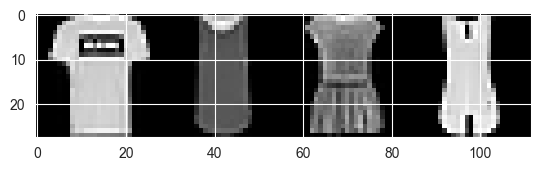

In [30]:
fashion_mnist=tf.keras.datasets.fashion_mnist
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data() ## From my understanding keras datasets are usually already split. Splitting datasets
orig = np.zeros((28, 112))
orig[:, :28] = x_train[1]
orig[:, 28:56] = x_train[2]
orig[:, 56:84] = x_train[3]
orig[:, 84:] = x_train[4]

print(f"The size of the data set, followed by image sizes {x_train.shape}")

plt.imshow(orig, cmap='gray');

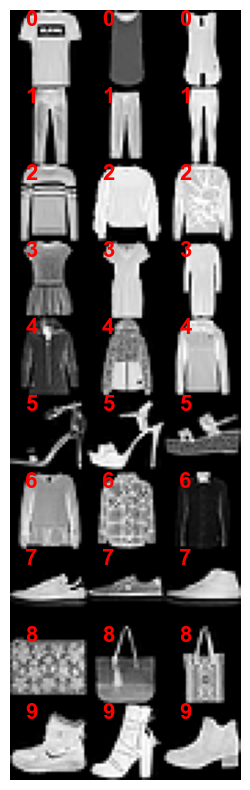

In [31]:
num_classes = 10
images_per_class = 3

grid_height = 28 * num_classes
grid_width = 28 * images_per_class
display_grid = np.zeros((grid_height, grid_width))

plt.figure(figsize=(10, 10))

for i in range(num_classes):

    class_indices = np.where(y_train == i)[0][:images_per_class]
    for j, idx in enumerate(class_indices):

        row_start, row_end = i * 28, (i + 1) * 28
        col_start, col_end = j * 28, (j + 1) * 28
        display_grid[row_start:row_end, col_start:col_end] = x_train[idx]
        plt.text(col_start + 5, row_start + 5, str(i), color='red', fontsize=16, weight='bold')

plt.imshow(display_grid, cmap='gray')
plt.axis('off')
plt.show()


In [32]:
labels_dict = {0: "shirt", 1: "trouser", 2: "pullover", 3: "dress", 4: "coat",
               5: "sandal", 6: "shirt", 7: "sneaker", 8: "bag", 9: "ankle boot"}

Y_test = [labels_dict[label] for label in y_test]

# EDA
To get a better understanding of the data set we can plot the dataset unto a 2d plot using PCA. As each datapoint consists of an image (28px x 28px) and therefore each datapoint consists of 784 features. PCA reduces the number of features while attempting to preserve information. New colomns or features are then created which correlate to the original colomns. We will then use PCA to reduce the datapoints to 2 features, ergo 2d.

Projecting 784-dimensional data to 2D


C:\Users\krist\AppData\Local\Temp\ipykernel_35824\3949814021.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('nipy_spectral', 10))


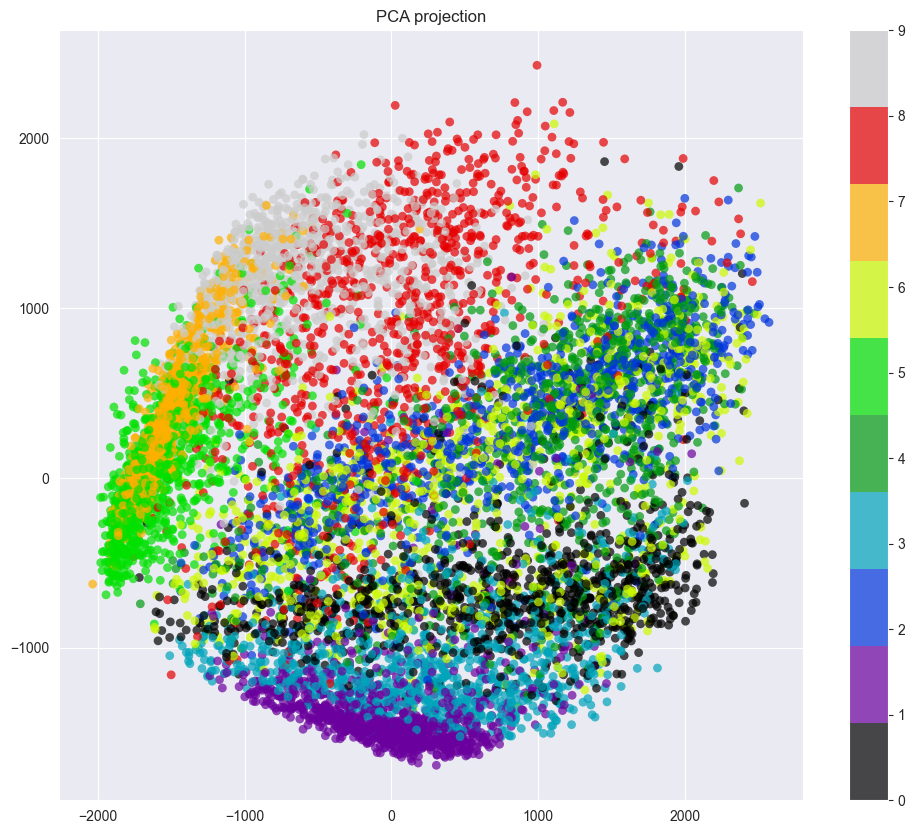

In [33]:
pca = PCA(n_components=2)
x_test = x_test.reshape((x_test.shape[0], -1))
x_reduced = pca.fit_transform(x_test)

print('Projecting %d-dimensional data to 2D' % x_test.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y_test,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('PCA projection');

The PCA was able to reduce the number of features and plot our dataset. We can see from the image that the all the classes are generally in the same vicinity of each other. The problem is there is huge overlap between the different classes. This kinda makes sense as we have classes that are similar: 7 orange, 9, black and 5 green are all in the same vicinity and overlap each other. These classes are all shoes and therefore are the features are similar.

Another issue is bags(8, red) are generally spread out all over the place. This will mean it will be potentially difficult to cluster.

This suggests that creating a clustering model to predict the class types will be difficult.

We will use PCA again to fix the dimensionality problem. As images get flattened from a 2d array to a 1d list. This means the ai algorithm potentially sees each pixel as its own separate feature that doesn't correlate to nearby pixels.

As Images have been flattened we are left with 784 features, ideally we want to reduce the number features to reduce the computational burden our computers will have to undergo. This is something that PCA will solve.

Earlier we reduced the number of components to two to properly plot the dataset. For us to effectively use PCA for machine learning we will have to determine the proper number of components. This can be done using the explained variance ratio. This is important because using PCA, some of the information from the dataset is lost. It is important to strike a balance between reducing features and losing critical information.

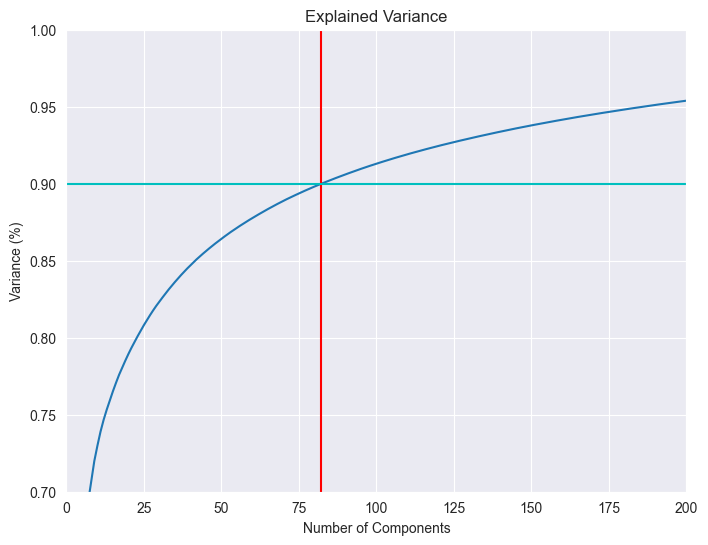

In [34]:
pca = PCA(n_components=None)
x_train = x_train.reshape((x_train.shape[0], -1))
pca.fit(x_train)

components = 82

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.axvline(components, c='r')
plt.axhline(0.9, c='c')
plt.xlim(0, 200)
plt.ylim(0.7, 1)
plt.grid(True)
plt.show()




The general rule of thumb for when using Explained variance ratio, is a threshold of 90% Variance explained. This will reduce the number of components without too much information loss. To determine the number of Components is then read by looking when the number components crosses 0.9 variance. From the plot we can read that it is at 82 components (red line). We will then be using 82 components when fitting our model with PCA.

In [35]:
pca = PCA(n_components=components)


x_train = pca.fit_transform(x_train)

## K means
K means is a clustering method. The sk learn library provides models ready to be trained which we will be making use of. Before training we will have to determine ideal number of number of clusters, $k$. $k$ is a hyperparameter and can be calculated using within cluster sum of squared errors (wss).

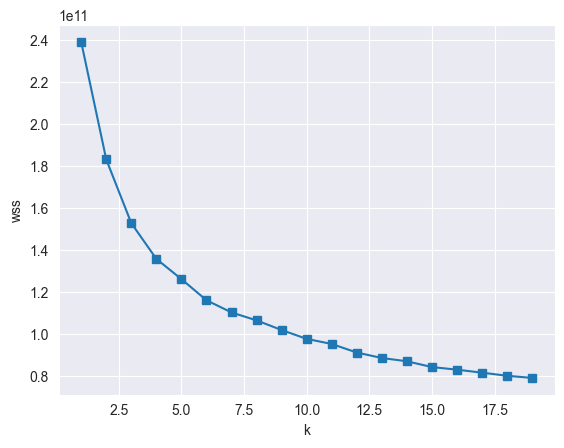

In [44]:
inertia = []
k_range = range(1, 20)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(x_train)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='s');
plt.xlabel('k')
plt.ylabel('wss');
plt.show()

To determine the ideal number of clusters you have to use the elbow technique. This is done by looking where there is a "crack" or "elbow" in the plot. Looking at the graph above it becomes apparent that it is not obviouse where this is. We will then have to use other methods to determine $k$.

Silhouette scores is another method in determine number of clusters. This is done in the following code.

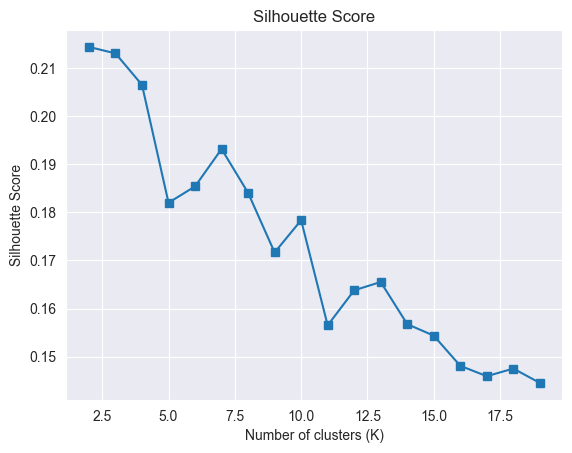

In [45]:


silhouette_scores = []
K_range = range(2, 20)

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=1).fit(x_train)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(x_train, labels))

plt.plot(K_range, silhouette_scores, marker='s')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

When using silhouette scores, $k$ can be determined by looking at the peaks. Looking at the graph we can see that the first peak is at 2 and from there it decreases. While the algorithm may have determined this to be the case, we will cheat a bit. As we know that the original dataset had 10classes we will strive for a number close to that, therefore we will chose the peak where $k$ = 7.

After determining $k$ we can finally train our model.

In [47]:
k = 7
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_train)

KMeans(n_clusters=7, random_state=42)

We can visualize then the clusters with their centrioids.

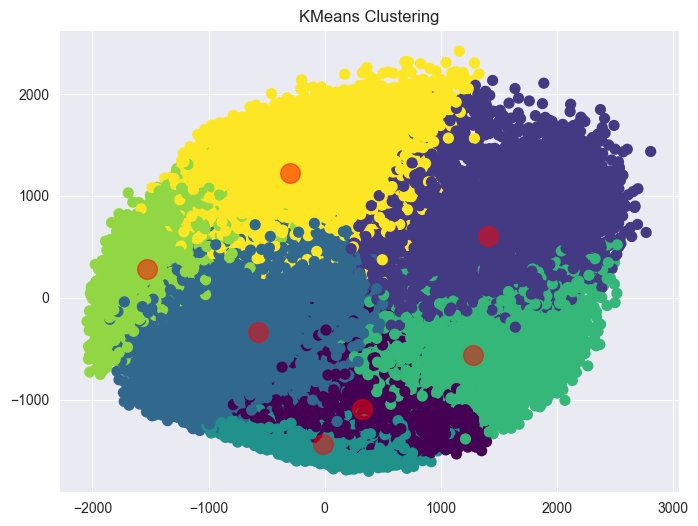

In [48]:
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(x_train[:, 0], x_train[:, 1], c=labels, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.title('KMeans Clustering')
plt.show()

There seems to be some overlap between clusters, particularly noticeable where different colors mix. This could suggest that the data has regions where the distinction between clusters is not very clear or that KMeans might not be the best model if the true clusters are not spherical or have varying sizes and densities. The centroids seem to be well placed within their respective clusters. For some of the more sparse clusters. The boundaries between some of the clusters appear to be well-defined, which is generally a good sign when using KMeans.

However the clusters don't seem to be difficulty seperated which indicates that KMeans has difficulty partitioning the space. As there seem to be one large blob or cluster, we understand better why the silhouette scoring suggested $k$ = 2.

In [ ]:
Just for fun, as we know we have 10 classes, we can attempt to train a model with $k$ = 10.

In [40]:
k = 10  # The ideal number of clusters you determined
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_train)

KMeans(n_clusters=10, random_state=42)

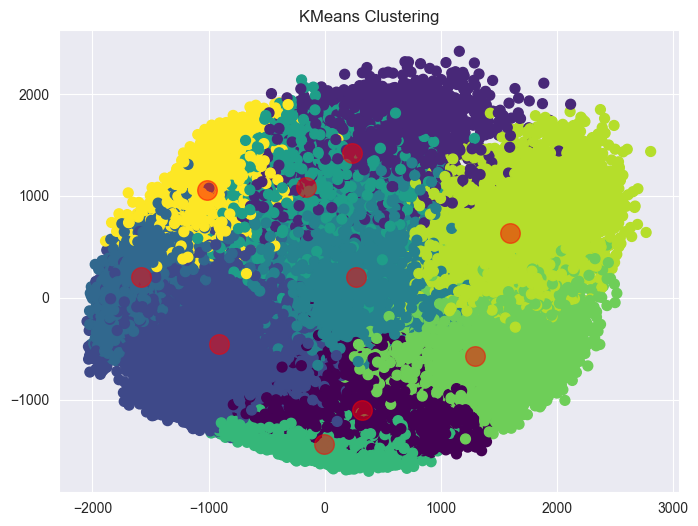

In [41]:
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(x_train[:, 0], x_train[:, 1], c=labels, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.title('KMeans Clustering')
plt.show()

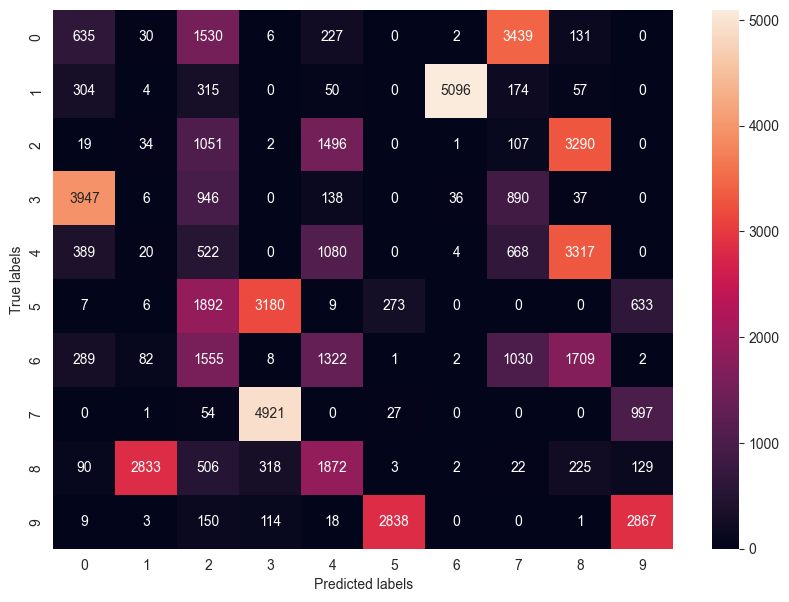

In [42]:
conf_matrix = confusion_matrix(y_train, labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In a well performing confusion matrix we'd expect to see high values in the diagonal. As we can see it seems to have performed poorly. It has performed alright in some cases, particularly correctly predicting ankle boots. There are noticeable off-diagonal values, which indicate misclassifications. For example, the true label 0 has a significant number of instances predicted as label 2, and the true label 3 has a significant number misclassified as label 4. This might indicate specific classes that your model is confusing or certain patterns in the data that are misleading the model.

While we have to be clear that classification is the main purpose for unsupervised learning.